In [ ]:
# Part 1
Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

In [1]:
import numpy as np
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import matplotlib.pyplot as plt
import nltk as nl
from nltk.corpus import stopwords as nlstopw
import re
import string


%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns

In [2]:
def plot_word_cloud(wordcloud):
    plt.imshow(wordcloud)
    plt.axis("off")

We take the _ExtractedBodyText_ field and not the _RawText_  ...

**TODO justify**

In [3]:
# read the raw emails:
emails = pd.read_csv('hillary-clinton-emails/Emails.csv', index_col='Id')
raw_text = ' '.join(emails.ExtractedBodyText.dropna().values)
emails.head()

,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,MetadataDocumentClass,ExtractedSubject,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
Id,,,,,,,,,,,,,,,,,,,,,
1,C05739545,WOW,H,"Sullivan, Jacob J",87.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739545...,F-2015-04841,HRC_Email_296,FW: Wow,NaN,"Sullivan, Jacob J <Sullivan11@state.gov>",NaN,"Wednesday, September 12, 2012 10:16 AM",F-2015-04841,C05739545,05/13/2015,RELEASE IN FULL,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
2,C05739546,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,H,NaN,NaN,2011-03-03T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739546...,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739546,05/13/2015,RELEASE IN PART,"B6\nThursday, March 3, 2011 9:45 PM\nH: Latest...",UNCLASSIFIED\nU.S. Department of State\nCase N...
3,C05739547,CHRIS STEVENS,;H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739547...,F-2015-04841,HRC_Email_296,Re: Chris Stevens,B6,"Mills, Cheryl D <MillsCD@state.gov>","Abedin, Huma","Wednesday, September 12, 2012 11:52 AM",F-2015-04841,C05739547,05/14/2015,RELEASE IN PART,Thx,UNCLASSIFIED\nU.S. Department of State\nCase N...
4,C05739550,CAIRO CONDEMNATION - FINAL,H,"Mills, Cheryl D",32.0,2012-09-12T04:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH2/DOC_0C05739550...,F-2015-04841,HRC_Email_296,FVV: Cairo Condemnation - Final,NaN,"Mills, Cheryl D <MillsCD@state.gov>","Mitchell, Andrew B","Wednesday, September 12,2012 12:44 PM",F-2015-04841,C05739550,05/13/2015,RELEASE IN PART,NaN,UNCLASSIFIED\nU.S. Department of State\nCase N...
5,C05739554,H: LATEST: HOW SYRIA IS AIDING QADDAFI AND MOR...,"Abedin, Huma",H,80.0,2011-03-11T05:00:00+00:00,2015-05-22T04:00:00+00:00,DOCUMENTS/HRC_Email_1_296/HRCH1/DOC_0C05739554...,F-2015-04841,HRC_Email_296,NaN,NaN,NaN,NaN,NaN,F-2015-04841,C05739554,05/13/2015,RELEASE IN PART,"H <hrod17@clintonemail.com>\nFriday, March 11,...",B6\nUNCLASSIFIED\nU.S. Department of State\nCa...


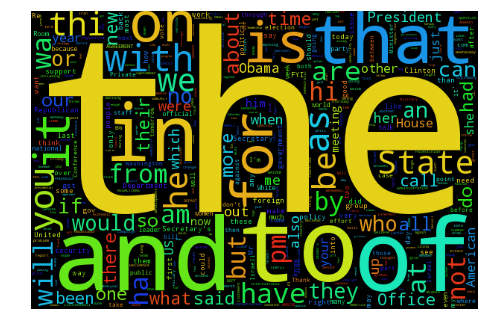

In [4]:
plot_word_cloud(WordCloud(stopwords=[''], width=600, height=400, prefer_horizontal=0.7, max_words=500, 
                          background_color='black').generate(raw_text))

On the raw corpus without stopword removal, _the_ is the most used word, followed by _and_, _in_, _of_, _to_ _From_ and _No_. 
Every english text would probably generate the same result.
The next wordcloud comes from the raw text of the first book of the _hitchikers guide to the galaxy_ series. Notice how similar they are.

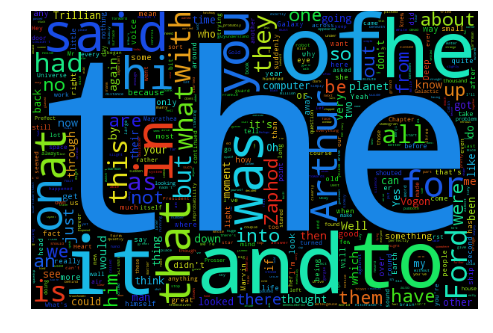

In [5]:
# source: http://paulyhart.blogspot.ch/2011/10/hitchhikers-guide-to-galaxy-text_28.html
httg_text = open('files/hitchikers_guide_to_the_galaxy.txt').read()
plot_word_cloud(WordCloud(stopwords=[''], width=600, height=400, prefer_horizontal=0.7, max_words=500, 
                          background_color='black').generate(httg_text))

WordCloud has their own stopwords, lets see what happens when we remove the default stopwords.
For the emails, we also include words like _UNCLASSIFIED_ _From_ _Sent_ _Subject_ etc to the Stoplist since these words appear in the email headers.

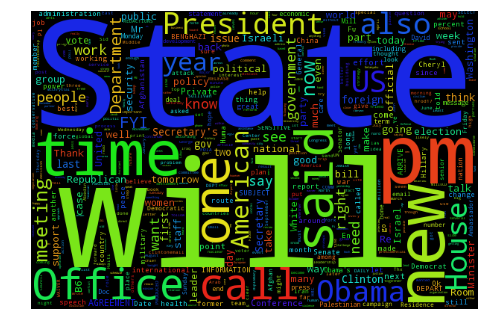

In [6]:
plot_word_cloud(WordCloud(stopwords=STOPWORDS, width=600, height=400, prefer_horizontal=0.7, max_words=500, 
                          background_color='black').generate(raw_text))

Already the two word clouds represent the text much better.

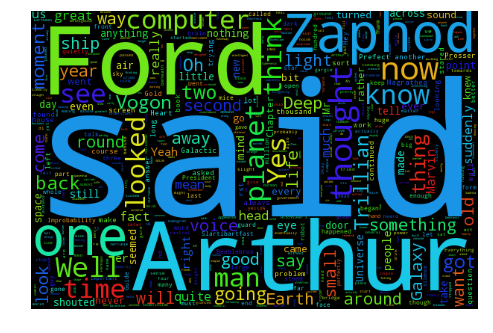

In [7]:
plot_word_cloud(WordCloud(stopwords=STOPWORDS, width=600, height=400, prefer_horizontal=0.7, max_words=500, 
                          background_color='black').generate(httg_text))

_Ford_, _Zaphod_ and _Arthur_ are the protagonists of the book.

Now lets create the pipeline:  tokenization, stopword removal, stemming

In [8]:
# remove punktuation
raw_text = re.sub('['+string.punctuation+']', '', raw_text)

In [9]:
# tokenize
nl.download('punkt') # needed for word tokenization
tokens = nl.word_tokenize(raw_text)
print("tokenized:", len(tokens))

# remove stopwords

tokens = [tok for tok in tokens if tok not in STOPWORDS]
print("stopw removed:", len(tokens))

# remove numbers
tokens = [tok for tok in tokens if not tok.isdigit()]
print("numbers removed:", len(tokens))


[nltk_data] Downloading package punkt to /home/lukas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
tokenized: 597025
stopw removed: 377452
numbers removed: 360571


In [10]:
tokens[:10]

['B6',
 'Thursday',
 'March',
 'PM',
 'H',
 'Latest',
 'How',
 'Syria',
 'aiding',
 'Qaddafi']

In [14]:
for i in range(7, -1, -1):
    print(i)

7
6
5
4
3
2
1
0
